In [56]:
from scipy.stats import beta
import operator
import numpy as np
from scipy.special import betaln
from random import shuffle
from collections import defaultdict
from prettytable import PrettyTable
import matplotlib.pyplot as plt
import seaborn as sns

In [57]:
dataset = 3
if dataset==0:
    # MovieLens-1M dataset
    ratings_file = '../data/ml-1m/ratings.dat'
    delimiter = '::'
elif dataset==1:
    # MovieLens-100k dataset
    ratings_file = '../data/ml-100k/u.data'
    delimiter = '\t'
elif dataset==2:
    # MovieLens-20k dataset
    ratings_file = '../data/ml-20k/u20k.data'
    delimiter = '\t'
elif dataset==3:
    ratings_file = '../data/filmtrust/ratings.txt'
    delimiter = ' '

In [3]:
def load_dataset():
    ratings = open(ratings_file, 'r').read().split('\n')[:-1]
    user_item_map = {}
    for r in ratings:
        attrs = r.split(delimiter)
        #if len(attrs) < 4:
        #    continue
        user = 'u' + attrs[0]
        item = 'i' + attrs[1]
        rating = float(attrs[2])
        if user in user_item_map:
            user_item_map[user][item] = rating
        else:
            user_item_map[user] = {}
            user_item_map[user][item] = rating
    for user in user_item_map:
        sum = 0
        for item in user_item_map[user]:
            sum += user_item_map[user][item]
        avg_rating_user = sum * 1.0 / len(user_item_map[user])
        for item in user_item_map[user]:
            if user_item_map[user][item] >= avg_rating_user:
                user_item_map[user][item] = 1
            else:
                user_item_map[user][item] = 0
    #for user in user_item_map.keys():
    #    if len(user_item_map[user]) < 10:
    #        del user_item_map[user]
    return user_item_map

In [4]:
def form_graph(user_item_map):
    graph = {}
    for user in user_item_map:
        if user not in graph:
            graph[user] = set([])
        for item in user_item_map[user]:
            if item not in graph:
                graph[item] = set([])
            graph[user].add(item)
            graph[item].add(user)
    return graph

In [5]:
def clean_graph(graph):
    while True:
        changed = False
        delete_nodes = []
        for node in graph:
            if len(graph[node]) < 10:
                changed = True
                delete_nodes.append(node)
        for node in delete_nodes:
            del graph[node]
        for node1 in graph:
            delete_nodes = []
            for node2 in graph[node1]:
                if node2 not in graph:
                    changed = True
                    delete_nodes.append(node2)
            for node2 in delete_nodes:
                graph[node1].remove(node2)
        if not changed:
            break
    for node in graph:
        graph[node] = list(graph[node])
    return graph

In [6]:
def get_num_ratings(user_item_map, graph):
    item_rating_map = {}
    for user in user_item_map:
        if user not in graph:
            continue
        for item in user_item_map[user]:
            if item not in graph:
                continue
            if item not in item_rating_map:
                item_rating_map[item] = [1, 1]
            if user_item_map[user][item] == 0:
                item_rating_map[item][1] += 1
            else:
                item_rating_map[item][0] += 1
    return item_rating_map

In [7]:
user_item_map = load_dataset()

In [8]:
graph = form_graph(user_item_map)

In [9]:
graph = clean_graph(graph)

In [10]:
item_rating_map = get_num_ratings(user_item_map, graph)

In [11]:
R = 0
U = 0
I = 0
delta_u = 0
delta_i = 0
total_i = 0

for u in graph:
    if 'i' in u:
        I += 1
        if len(graph[u]) > delta_i:
            delta_i = len(graph[u])
        total_i += len(graph[u])
        continue
    U += 1
    R += len(graph[u])
    if len(graph[u]) > delta_u:
        delta_u = len(graph[u])
    
print 'Number of ratings: ' + str(R)
print 'Number of users: ' + str(U)
print 'Number of items: ' + str(I)
print 'Delta_U: ' + str(delta_u)
print 'Delta_I: ' + str(delta_i)
print 'Gamma_U: ' + str(R * 1.0 / U)
print 'Gamma_I: ' + str(total_i * 1.0 / I)

Number of ratings: 28317
Number of users: 949
Number of items: 159
Delta_U: 83
Delta_I: 848
Gamma_U: 29.8387776607
Gamma_I: 178.094339623


## Split dataset so that for each user, 80% is training, 20% is for test


In [12]:
first_20percent_of_u1 = [graph['u1'][i] for i in range(int(0.2*len(graph['u1'])))] 
print first_20percent_of_u1

['i9', 'i8']


In [13]:
len(graph['u1'])

12

In [14]:
graph['u1'][3]

'i5'

In [15]:
# Input: a graph called g
# Output: two test sets, one containing 20% of g's items per user, 
#         the other containing 80% 

def create_sets(g): 
    test_set = defaultdict(list) 
    training_set = defaultdict(list)
    
    for key in g:
        if key[0]=='u': 
            indices = [x for x in xrange(len(g[key]))]
            shuffle(indices)
            # For length of items belonging to that key, split 20% and 80%
            first_80 = int(0.8*len(g[key]))
            
            for i in range(first_80): 
                training_set[key].append(g[key][indices[i]])

            for j in range(first_80, len(g[key])):
                test_set[key].append(g[key][indices[j]])
            
    for user in test_set.keys():
        for item in test_set[user]:
            test_set[item].append(user)
            
    for user in training_set.keys(): 
        for item in training_set[user]: 
            training_set[item].append(user)
            
    return test_set, training_set

In [16]:
test_set, training_set = create_sets(graph)

In [17]:
print first_20percent_of_u1 == test_set['u1']

False


In [18]:
print "movie_100k_test_set has ", len(test_set.keys()), "keys"
print "movie_100k_training_set has ", len(training_set.keys()), " keys"

movie_100k_test_set has  1105 keys
movie_100k_training_set has  1108  keys


## User-User Similarity

In [19]:
def find_user_similarity(graph):
    users = []
    for key in graph:
        if 'u' in key:
            users.append(key)
    similarity = np.zeros((1600+1, 1600+1))
    count = np.zeros((1600+1,1600+1))
    #similarity = np.zeros((len(users) + 1, len(users) + 1))
    #count = np.zeros((len(users) + 1, len(users) + 1))
    np.fill_diagonal(similarity, 1)
    np.fill_diagonal(count, 1)
    for u1 in users:
        for u2 in users:
            if u1 == u2:
                continue
            for item in graph[u1]:
                if item in graph[u2]:
                    count[int(u1[1:]), int(u2[1:])] += 1
                    if user_item_map[u1][item] == user_item_map[u2][item]:
                        similarity[int(u1[1:]), int(u2[1:])] += 1
                    else:
                        similarity[int(u1[1:]), int(u2[1:])] -= 1
            count[int(u2[1:]), int(u1[1:])] = count[int(u1[1:]), int(u2[1:])]
            similarity[int(u2[1:]), int(u1[1:])] = similarity[int(u1[1:]), int(u2[1:])]
    return np.divide(similarity, count)

In [20]:
user_similarity = find_user_similarity(training_set)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide


In [21]:
user_similarity[np.isnan(user_similarity)] = -1
min_value = user_similarity.min()
max_value = user_similarity.max()
user_similarity = (user_similarity - min_value) / (max_value - min_value)

In [22]:
print len(np.argwhere(user_similarity[:, :] > 0.5)) * 1.0 / (1601**2)
print min_value
print max_value

0.168283720239
-1.0
1.0


## Item-Item Similarity

In [23]:
# Input: the same graph of both users and items that was used for find_user_similarity
# Output: item-item similarity matrix 
'''def find_item_similarity(graph):
    items = []
    for key in graph:
        if 'i' in key:
            items.append(key)
    
    similarity = np.zeros((len(items), len(items)))
    
    # How many times the same users have rated a pair of items
    count = np.zeros((len(items), len(items)))
    
    np.fill_diagonal(similarity, 1)
    np.fill_diagonal(count, 1)

    # Dictionary to map item ID to index in similarity matrix 
    id_to_index = {} 
    
    for i in range(len(items)): 
        id_to_index[items[i]] = i
    
    # Fill similarity/count matrices 
    for i1 in items: 
        for i2 in items: 
            if i1 == i2: 
                continue 
            
            i1_id = id_to_index[i1] 
            i2_id = id_to_index[i2]
            
            for user in graph[i1]: # for i1, list of users who have rated it
                if user in graph[i2]: # if that same user has also rated i2  
                    count[i1_id, i2_id] += 1
                    
                    # If this user rated i1 and i2 the same 
                    if user_item_map[user][i1] == user_item_map[user][i2]: 
                        similarity[i1_id, i2_id] += 1.0
                    else: 
                        similarity[i1_id, i2_id] -= 1.0
            
            # Upon completing the for loop, make sure the reverse pair in the 
            # similarity and count matrices have the same value (e.g. make a,b = b,a)
            similarity[i2_id, i1_id] = similarity[i1_id, i2_id]
            count[i2_id, i1_id] = count[i1_id, i2_id]
    return np.divide(similarity, count)'''

"def find_item_similarity(graph):\n    items = []\n    for key in graph:\n        if 'i' in key:\n            items.append(key)\n    \n    similarity = np.zeros((len(items), len(items)))\n    \n    # How many times the same users have rated a pair of items\n    count = np.zeros((len(items), len(items)))\n    \n    np.fill_diagonal(similarity, 1)\n    np.fill_diagonal(count, 1)\n\n    # Dictionary to map item ID to index in similarity matrix \n    id_to_index = {} \n    \n    for i in range(len(items)): \n        id_to_index[items[i]] = i\n    \n    # Fill similarity/count matrices \n    for i1 in items: \n        for i2 in items: \n            if i1 == i2: \n                continue \n            \n            i1_id = id_to_index[i1] \n            i2_id = id_to_index[i2]\n            \n            for user in graph[i1]: # for i1, list of users who have rated it\n                if user in graph[i2]: # if that same user has also rated i2  \n                    count[i1_id, i2_id] += 1\n

In [24]:
def find_item_similarity(graph):
    items = []
    for key in graph:
        if 'i' in key:
            items.append(key)
    similarity = np.zeros((2071+1, 2071+1))
    count = np.zeros((2071+1,2071+1))
    #similarity = np.zeros((len(users) + 1, len(users) + 1))
    #count = np.zeros((len(users) + 1, len(users) + 1))
    np.fill_diagonal(similarity, 1)
    np.fill_diagonal(count, 1)
    for i1 in items:
        for i2 in items:
            if i1 == i2:
                continue
            for user in graph[i1]:
                if user in graph[i2]:
                    count[int(i1[1:]), int(i2[1:])] += 1
                    if user_item_map[user][i1] == user_item_map[user][i2]:
                        similarity[int(i1[1:]), int(i2[1:])] += 1
                    else:
                        similarity[int(i1[1:]), int(i2[1:])] -= 1
            count[int(i2[1:]), int(i1[1:])] = count[int(i1[1:]), int(i2[1:])]
            similarity[int(i2[1:]), int(i1[1:])] = similarity[int(i1[1:]), int(i2[1:])]
    return np.divide(similarity, count)

In [25]:
item_similarity = find_item_similarity(training_set)

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:25: RuntimeWarning: invalid value encountered in divide


In [26]:
item_similarity[np.isnan(item_similarity)] = -1
min_value = item_similarity.min()
max_value = item_similarity.max()

# Normalize all values in the matrix to be b/w 0 and 1
item_similarity = (item_similarity - min_value) / (max_value - min_value)

In [27]:
print len(item_similarity)
print len(np.argwhere(item_similarity[:, :] == 0)) * 1.0 / (len(item_similarity)**2)
print min_value
print max_value

2072
0.995284618595
-1.0
1.0


# Scoring Functions

In [28]:
def PIS(item_pair):
    item1 = item_pair[0]
    item2 = item_pair[1]
    total = 0
    for i in range(0,item_rating_map[item2][0]):
        total += np.exp(betaln(item_rating_map[item1][0]+i,item_rating_map[item1][1]+item_rating_map[item2][1]) -\
                        np.log(item_rating_map[item2][1]+i) - \
                        betaln(1+i, item_rating_map[item2][1]) -\
                        betaln(item_rating_map[item1][0],item_rating_map[item1][1])
                       )
    return total

In [29]:
def PPS(item_pair):
    item1 = item_pair[0]
    item2 = item_pair[1]
    p1 = (item_rating_map[item1][0] + 1) * 1.0 / (item_rating_map[item1][0] + item_rating_map[item1][1] + 1)
    p2 = (item_rating_map[item2][0] + 1) * 1.0 / (item_rating_map[item2][0] + item_rating_map[item2][1] + 1)
    return p1 * p2

In [30]:
def PORS(item_pair):
    item1 = item_pair[0]
    item2 = item_pair[1]
    o1 = (item_rating_map[item1][0] + 1) * 1.0 / (item_rating_map[item1][1] + 1)
    o2 = (item_rating_map[item2][0] + 1) * 1.0 / (item_rating_map[item2][1] + 1)
    return o2 / o1

In [31]:
def USS(u1, i1, u2, i2):
    reliability = item_rating_map[i2][0] * 1.0 / (item_rating_map[i2][0] + item_rating_map[i2][1])
    indicator = 1
    if user_item_map[u2][i2] == 0:
        indicator = 0
    similarity = user_similarity[int(u1[1:]), int(u2[1:])]
    return reliability * similarity * indicator + reliability * (1.0 - similarity) * (1 - indicator)

In [32]:
# Input: A pair of user-item 
# Output: item similarity score 
def ISS(u1, i1, u2, i2):
    reliability = item_rating_map[i2][0] * 1.0 / (item_rating_map[i2][0] + item_rating_map[i2][1])
    indicator = 1
    if user_item_map[u2][i2] == 0:
        indicator = 0
    similarity = item_similarity[int(i1[1:]), int(i2[1:])]
    return reliability * similarity * indicator + reliability * (1.0 - similarity) * (1 - indicator)

In [33]:
relevance = {}
maximum = 0

for key in training_set:
    if 'u' in key:
        relevance[key] = len(training_set[key])
        if maximum < relevance[key]:
            maximum = relevance[key]
            
for key in relevance:
    relevance[key] = relevance[key] * 1.0 / maximum

In [34]:
def score(graph, target_user):
    PIS_values = defaultdict(float)
    PPS_values = defaultdict(float)
    PORS_values = defaultdict(float)
    
    score_PIS = defaultdict(float)
    score_PPS = defaultdict(float)
    score_PORS = defaultdict(float)
    
    score_PIS_USS = defaultdict(float)
    score_PPS_USS = defaultdict(float)
    score_PORS_USS = defaultdict(float)
    
    score_PIS_ISS = defaultdict(float)
    score_PPS_ISS = defaultdict(float)
    score_PORS_ISS = defaultdict(float)
    
    score_PIS_USS_ISS = defaultdict(float)
    score_PPS_USS_ISS = defaultdict(float)
    score_PORS_USS_ISS = defaultdict(float)
    
    score_rel_PIS = defaultdict(float)
    score_rel_PPS = defaultdict(float)
    score_rel_PORS = defaultdict(float)
    
    score_rel_PIS_USS = defaultdict(float)
    score_rel_PPS_USS = defaultdict(float)
    score_rel_PORS_USS = defaultdict(float)
    
    score_rel_PIS_ISS = defaultdict(float)
    score_rel_PPS_ISS = defaultdict(float)
    score_rel_PORS_ISS = defaultdict(float)
    
    score_rel_PIS_USS_ISS = defaultdict(float)
    score_rel_PPS_USS_ISS = defaultdict(float)
    score_rel_PORS_USS_ISS = defaultdict(float)
    
    for primary_item in graph[target_user]:
        for secondary_user in graph[primary_item]:
            if secondary_user == target_user:
                continue
            for secondary_item in graph[secondary_user]:
                if secondary_item in graph[target_user]:
                    continue
                
                if (primary_item, secondary_item) not in PIS_values:
                    PIS_values[(primary_item, secondary_item)] = PIS((primary_item, secondary_item))
                score_PIS[secondary_item] += PIS_values[(primary_item, secondary_item)]
                score_PIS_USS[secondary_item] += PIS_values[(primary_item, secondary_item)] * user_similarity[int(target_user[1:]), int(secondary_user[1:])]
                score_PIS_ISS[secondary_item] += PIS_values[(primary_item, secondary_item)] * item_similarity[int(primary_item[1:]), int(secondary_item[1:])]
                score_PIS_USS_ISS[secondary_item] += PIS_values[(primary_item, secondary_item)] * user_similarity[int(target_user[1:]), int(secondary_user[1:])] * item_similarity[int(primary_item[1:]), int(secondary_item[1:])]
                
                score_rel_PIS[secondary_item] += PIS_values[(primary_item, secondary_item)] * relevance[secondary_user]
                score_rel_PIS_USS[secondary_item] += PIS_values[(primary_item, secondary_item)] * user_similarity[int(target_user[1:]), int(secondary_user[1:])] * relevance[secondary_user]
                score_rel_PIS_ISS[secondary_item] += PIS_values[(primary_item, secondary_item)] * item_similarity[int(primary_item[1:]), int(secondary_item[1:])] * relevance[secondary_user]
                score_rel_PIS_USS_ISS[secondary_item] += PIS_values[(primary_item, secondary_item)] * user_similarity[int(target_user[1:]), int(secondary_user[1:])] * item_similarity[int(primary_item[1:]), int(secondary_item[1:])] * relevance[secondary_user]
                
                
                if (primary_item, secondary_item) not in PPS_values:
                    PPS_values[(primary_item, secondary_item)] = PPS((primary_item, secondary_item))
                score_PPS[secondary_item] += PPS_values[(primary_item, secondary_item)]
                score_PPS_USS[secondary_item] += PPS_values[(primary_item, secondary_item)] * user_similarity[int(target_user[1:]), int(secondary_user[1:])]
                score_PPS_ISS[secondary_item] += PPS_values[(primary_item, secondary_item)] * item_similarity[int(primary_item[1:]), int(secondary_item[1:])]
                score_PPS_USS_ISS[secondary_item] += PPS_values[(primary_item, secondary_item)] * user_similarity[int(target_user[1:]), int(secondary_user[1:])] * item_similarity[int(primary_item[1:]), int(secondary_item[1:])]
                
                score_rel_PPS[secondary_item] += PPS_values[(primary_item, secondary_item)] * relevance[secondary_user]
                score_rel_PPS_USS[secondary_item] += PPS_values[(primary_item, secondary_item)] * user_similarity[int(target_user[1:]), int(secondary_user[1:])] * relevance[secondary_user]
                score_rel_PPS_ISS[secondary_item] += PPS_values[(primary_item, secondary_item)] * item_similarity[int(primary_item[1:]), int(secondary_item[1:])] * relevance[secondary_user]
                score_rel_PPS_USS_ISS[secondary_item] += PPS_values[(primary_item, secondary_item)] * user_similarity[int(target_user[1:]), int(secondary_user[1:])] * item_similarity[int(primary_item[1:]), int(secondary_item[1:])] * relevance[secondary_user]
                
                
                if (primary_item, secondary_item) not in PORS_values:
                    PORS_values[(primary_item, secondary_item)] = PORS((primary_item, secondary_item))
                score_PORS[secondary_item] += PORS_values[(primary_item, secondary_item)]
                score_PORS_USS[secondary_item] += PORS_values[(primary_item, secondary_item)] * user_similarity[int(target_user[1:]), int(secondary_user[1:])]
                score_PORS_ISS[secondary_item] += PORS_values[(primary_item, secondary_item)] * item_similarity[int(primary_item[1:]), int(secondary_item[1:])]
                score_PORS_USS_ISS[secondary_item] += PORS_values[(primary_item, secondary_item)] * user_similarity[int(target_user[1:]), int(secondary_user[1:])] * item_similarity[int(primary_item[1:]), int(secondary_item[1:])]
                
                score_rel_PORS[secondary_item] += PORS_values[(primary_item, secondary_item)] * relevance[secondary_user]
                score_rel_PORS_USS[secondary_item] += PORS_values[(primary_item, secondary_item)] * user_similarity[int(target_user[1:]), int(secondary_user[1:])] * relevance[secondary_user]
                score_rel_PORS_ISS[secondary_item] += PORS_values[(primary_item, secondary_item)] * item_similarity[int(primary_item[1:]), int(secondary_item[1:])] * relevance[secondary_user]
                score_rel_PORS_USS_ISS[secondary_item] += PORS_values[(primary_item, secondary_item)] * user_similarity[int(target_user[1:]), int(secondary_user[1:])] * item_similarity[int(primary_item[1:]), int(secondary_item[1:])] * relevance[secondary_user]

    return score_PIS, score_PIS_USS, score_PIS_ISS, score_PIS_USS_ISS, score_rel_PIS, score_rel_PIS_USS, score_rel_PIS_ISS, score_rel_PIS_USS_ISS, score_PPS, score_PPS_USS, score_PPS_ISS, score_PPS_USS_ISS, score_rel_PPS, score_rel_PPS_USS, score_rel_PPS_ISS, score_rel_PPS_USS_ISS, score_PORS, score_PORS_USS, score_PORS_ISS, score_PORS_USS_ISS, score_rel_PORS, score_rel_PORS_USS, score_rel_PORS_ISS, score_rel_PORS_USS_ISS 




## Generate 3 lists of ranking scores per item for PIS, PPS, PORS

In [36]:
# ******Caution: the code in this box will need to run overnight due to the size of the test_set****** 

# Input:  One of the score dictionaries generated by calling rank(graph, key) 
# Output: A ranking list for each user, where the most highly recommended items come first (no need to store
#         the score that was associated with that item)
def generate_ranking_list(score_list): 
    ranking_list = {} 

    for user in score_list: 
        # Sort the score list for that user 
        sorted_score = sorted(score_list[user].items(), key=operator.itemgetter(1), reverse=True)
        ranking_list[user]= [item[0] for item in sorted_score]

    return ranking_list 

# For each of the 3 methods, generate scores as a dictionary where 
# Key = User, Value = List of (item,score) pairs 
score_PIS = {} 
score_PPS = {} 
score_PORS = {}
score_PIS_USS = {}
score_PPS_USS = {}
score_PORS_USS = {}
score_PIS_ISS = {}
score_PPS_ISS = {}
score_PORS_ISS = {}
score_PIS_USS_ISS = {}
score_PPS_USS_ISS = {}
score_PORS_USS_ISS = {}
score_rel_PIS = {}
score_rel_PPS = {}
score_rel_PORS = {}
score_rel_PIS_USS = {}
score_rel_PPS_USS = {}
score_rel_PORS_USS = {}
score_rel_PIS_ISS = {}
score_rel_PPS_ISS = {}
score_rel_PORS_ISS = {}
score_rel_PIS_USS_ISS = {}
score_rel_PPS_USS_ISS = {}
score_rel_PORS_USS_ISS = {}

count = 0
for user in training_set:
    if user[0] == 'u':
        score_PIS[user], score_PIS_USS[user], score_PIS_ISS[user], score_PIS_USS_ISS[user], score_rel_PIS[user], score_rel_PIS_USS[user], score_rel_PIS_ISS[user], score_rel_PIS_USS_ISS[user], score_PPS[user], score_PPS_USS[user], score_PPS_ISS[user], score_PPS_USS_ISS[user], score_rel_PPS[user], score_rel_PPS_USS[user], score_rel_PPS_ISS[user], score_rel_PPS_USS_ISS[user], score_PORS[user], score_PORS_USS[user], score_PORS_ISS[user], score_PORS_USS_ISS[user], score_rel_PORS[user], score_rel_PORS_USS[user], score_rel_PORS_ISS[user], score_rel_PORS_USS_ISS[user] = score(training_set, user)
        count += 1
        if count%1==0:
            print count,' Users done'
        
# Generate 3 lists of ranking scores per item for PIS, PPS, PORS
ranking_PIS = generate_ranking_list(score_PIS)
ranking_PPS = generate_ranking_list(score_PPS)
ranking_PORS = generate_ranking_list(score_PORS)
ranking_PIS_USS = generate_ranking_list(score_PIS_USS)
ranking_PPS_USS = generate_ranking_list(score_PPS_USS)
ranking_PORS_USS = generate_ranking_list(score_PORS_USS)
ranking_PIS_ISS = generate_ranking_list(score_PIS_ISS)
ranking_PPS_ISS = generate_ranking_list(score_PPS_ISS)
ranking_PORS_ISS = generate_ranking_list(score_PORS_ISS)
ranking_PIS_USS_ISS = generate_ranking_list(score_PIS_USS_ISS)
ranking_PPS_USS_ISS = generate_ranking_list(score_PPS_USS_ISS)
ranking_PORS_USS_ISS = generate_ranking_list(score_PORS_USS_ISS)

ranking_rel_PIS = generate_ranking_list(score_rel_PIS)
ranking_rel_PPS = generate_ranking_list(score_rel_PPS)
ranking_rel_PORS = generate_ranking_list(score_rel_PORS)
ranking_rel_PIS_USS = generate_ranking_list(score_rel_PIS_USS)
ranking_rel_PPS_USS = generate_ranking_list(score_rel_PPS_USS)
ranking_rel_PORS_USS = generate_ranking_list(score_rel_PORS_USS)
ranking_rel_PIS_ISS = generate_ranking_list(score_rel_PIS_ISS)
ranking_rel_PPS_ISS = generate_ranking_list(score_rel_PPS_ISS)
ranking_rel_PORS_ISS = generate_ranking_list(score_rel_PORS_ISS)
ranking_rel_PIS_USS_ISS = generate_ranking_list(score_rel_PIS_USS_ISS)
ranking_rel_PPS_USS_ISS = generate_ranking_list(score_rel_PPS_USS_ISS)
ranking_rel_PORS_USS_ISS = generate_ranking_list(score_rel_PORS_USS_ISS)

1  Users done
2  Users done
3  Users done
4  Users done
5  Users done
6  Users done
7  Users done
8  Users done
9  Users done
10  Users done
11  Users done
12  Users done
13  Users done
14  Users done
15  Users done
16  Users done
17  Users done
18  Users done
19  Users done
20  Users done
21  Users done
22  Users done
23  Users done
24  Users done
25  Users done
26  Users done
27  Users done
28  Users done
29  Users done
30  Users done
31  Users done
32  Users done
33  Users done
34  Users done
35  Users done
36  Users done
37  Users done
38  Users done
39  Users done
40  Users done
41  Users done
42  Users done
43  Users done
44  Users done
45  Users done
46  Users done
47  Users done
48  Users done
49  Users done
50  Users done
51  Users done
52  Users done
53  Users done
54  Users done
55  Users done
56  Users done
57  Users done
58  Users done
59  Users done
60  Users done
61  Users done
62  Users done
63  Users done
64  Users done
65  Users done
66  Users done
67  Users done
68  

520  Users done
521  Users done
522  Users done
523  Users done
524  Users done
525  Users done
526  Users done
527  Users done
528  Users done
529  Users done
530  Users done
531  Users done
532  Users done
533  Users done
534  Users done
535  Users done
536  Users done
537  Users done
538  Users done
539  Users done
540  Users done
541  Users done
542  Users done
543  Users done
544  Users done
545  Users done
546  Users done
547  Users done
548  Users done
549  Users done
550  Users done
551  Users done
552  Users done
553  Users done
554  Users done
555  Users done
556  Users done
557  Users done
558  Users done
559  Users done
560  Users done
561  Users done
562  Users done
563  Users done
564  Users done
565  Users done
566  Users done
567  Users done
568  Users done
569  Users done
570  Users done
571  Users done
572  Users done
573  Users done
574  Users done
575  Users done
576  Users done
577  Users done
578  Users done
579  Users done
580  Users done
581  Users done
582  Use

In [37]:
def get_lp_ln(predictions):
    lp = defaultdict(list)
    ln = defaultdict(list)
    for user in predictions:
        for item in test_set[user]:
            if user_item_map[user][item] == 1:
                lp[user].append(item)
            else:
                ln[user].append(item)
    return lp,ln

def p_at_k(k, predictions, lp):
    patk = 0.0
    for user in predictions:
        correct = 0
        for i in range(k):
            if predictions[user][i] in lp[user]:
                correct+=1
        patk += 1.0*correct/k
    return patk/len(predictions.keys())

def MAP(predictions, lp):
    MAP = 0.0
    for user in predictions:
        umap = 0.0
        correct = 0
        for i in range(len(predictions[user])):
            if predictions[user][i] in lp[user]:
                correct += 1
                umap += 1.0*correct/(i+1)
        MAP += umap/max(1,len(lp[user]))
    return MAP/len(predictions.keys())

def MRR(predictions, lp):
    MRR = 0.0
    for user in predictions:
        for i in range(len(predictions[user])):
            if predictions[user][i] in lp[user]:
                MRR += 1.0/(i+1)
                break
    return MRR/len(predictions.keys())

def rel(item, u_lp, u_ln):
    if item in u_lp:
        return 2
    elif item in u_ln:
        return 1
    else:
        return 0

    u_dcg = 0.0
    for i in range(0,n):
        if i==0:
            u_dcg += rel(u_pred[i], u_lp, u_ln)
        else:
            u_dcg += rel(u_pred[i], u_lp, u_ln)/np.log2(i+1)
    return u_dcg
    
def idcg_at_n(n, u_pred, u_lp, u_ln):
    rel_scores = []
    for item in u_pred:
        rel_scores.append(rel(item, u_lp, u_ln))
    rel_scores = sorted(rel_scores, reverse=True)
    u_idcg = rel_scores[0]
    for i in range(1,n):
        u_idcg += rel_scores[i]/np.log2(i+1)
    return u_idcg
        
def ndcg_at_n(n, predictions, lp, ln):
    ndcg = 0.0
    for user in predictions:
        u_dcg = dcg_at_n(n, predictions[user], lp[user], ln[user])
        u_idcg = idcg_at_n(n, predictions[user], lp[user], ln[user])
        ndcg += u_dcg/u_idcg
    return ndcg/len(predictions.keys())



In [112]:
scores = {'MAP':defaultdict(float), 'MRR':defaultdict(float), 'P@5':defaultdict(float), 'P@10':defaultdict(float), 'NDCG@5':defaultdict(float), 'NDCG@10':defaultdict(float)}
t = PrettyTable(['Method', 'MAP', 'MRR', 'P@5', 'P@10', 'NDCG@5', 'NDCG@10'])

predictions = ranking_PIS
lp, ln = get_lp_ln(predictions)
scores['MAP']['PIS'] = MAP(predictions, lp)
scores['MRR']['PIS'] = MRR(predictions, lp)
scores['P@5']['PIS'] = p_at_k(5, predictions, lp)
scores['P@10']['PIS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['PIS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['PIS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['PIS', scores['MAP']['PIS'], scores['MRR']['PIS'], scores['P@5']['PIS'], scores['P@10']['PIS'], scores['NDCG@5']['PIS'], scores['NDCG@10']['PIS']])

predictions = ranking_PIS_USS
lp, ln = get_lp_ln(predictions)
scores['MAP']['PIS_USS'] = MAP(predictions, lp)
scores['MRR']['PIS_USS'] = MRR(predictions, lp)
scores['P@5']['PIS_USS'] = p_at_k(5, predictions, lp)
scores['P@10']['PIS_USS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['PIS_USS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['PIS_USS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['PIS_USS', scores['MAP']['PIS_USS'], scores['MRR']['PIS_USS'], scores['P@5']['PIS_USS'], scores['P@10']['PIS_USS'], scores['NDCG@5']['PIS_USS'], scores['NDCG@10']['PIS_USS']])

predictions = ranking_PIS_ISS
lp, ln = get_lp_ln(predictions)
scores['MAP']['PIS_ISS'] = MAP(predictions, lp)
scores['MRR']['PIS_ISS'] = MRR(predictions, lp)
scores['P@5']['PIS_ISS'] = p_at_k(5, predictions, lp)
scores['P@10']['PIS_ISS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['PIS_ISS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['PIS_ISS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['PIS_ISS', scores['MAP']['PIS_ISS'], scores['MRR']['PIS_ISS'], scores['P@5']['PIS_ISS'], scores['P@10']['PIS_ISS'], scores['NDCG@5']['PIS_ISS'], scores['NDCG@10']['PIS_ISS']])

predictions = ranking_PIS_USS_ISS
lp, ln = get_lp_ln(predictions)
scores['MAP']['PIS_USS_ISS'] = MAP(predictions, lp)
scores['MRR']['PIS_USS_ISS'] = MRR(predictions, lp)
scores['P@5']['PIS_USS_ISS'] = p_at_k(5, predictions, lp)
scores['P@10']['PIS_USS_ISS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['PIS_USS_ISS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['PIS_USS_ISS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['PIS_USS_ISS', scores['MAP']['PIS_USS_ISS'], scores['MRR']['PIS_USS_ISS'], scores['P@5']['PIS_USS_ISS'], scores['P@10']['PIS_USS_ISS'], scores['NDCG@5']['PIS_USS_ISS'], scores['NDCG@10']['PIS_USS_ISS']])

predictions = ranking_rel_PIS
lp, ln = get_lp_ln(predictions)
scores['MAP']['rel_PIS'] = MAP(predictions, lp)
scores['MRR']['rel_PIS'] = MRR(predictions, lp)
scores['P@5']['rel_PIS'] = p_at_k(5, predictions, lp)
scores['P@10']['rel_PIS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['rel_PIS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['rel_PIS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['rel_PIS', scores['MAP']['rel_PIS'], scores['MRR']['rel_PIS'], scores['P@5']['rel_PIS'], scores['P@10']['rel_PIS'], scores['NDCG@5']['rel_PIS'], scores['NDCG@10']['rel_PIS']])

predictions = ranking_rel_PIS_USS
lp, ln = get_lp_ln(predictions)
scores['MAP']['rel_PIS_USS'] = MAP(predictions, lp)
scores['MRR']['rel_PIS_USS'] = MRR(predictions, lp)
scores['P@5']['rel_PIS_USS'] = p_at_k(5, predictions, lp)
scores['P@10']['rel_PIS_USS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['rel_PIS_USS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['rel_PIS_USS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['rel_PIS_USS', scores['MAP']['rel_PIS_USS'], scores['MRR']['rel_PIS_USS'], scores['P@5']['rel_PIS_USS'], scores['P@10']['rel_PIS_USS'], scores['NDCG@5']['rel_PIS_USS'], scores['NDCG@10']['rel_PIS_USS']])

predictions = ranking_rel_PIS_ISS
lp, ln = get_lp_ln(predictions)
scores['MAP']['rel_PIS_ISS'] = MAP(predictions, lp)
scores['MRR']['rel_PIS_ISS'] = MRR(predictions, lp)
scores['P@5']['rel_PIS_ISS'] = p_at_k(5, predictions, lp)
scores['P@10']['rel_PIS_ISS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['rel_PIS_ISS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['rel_PIS_ISS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['rel_PIS_ISS', scores['MAP']['rel_PIS_ISS'], scores['MRR']['rel_PIS_ISS'], scores['P@5']['rel_PIS_ISS'], scores['P@10']['rel_PIS_ISS'], scores['NDCG@5']['rel_PIS_ISS'], scores['NDCG@10']['rel_PIS_ISS']])

predictions = ranking_rel_PIS_USS_ISS
lp, ln = get_lp_ln(predictions)
scores['MAP']['rel_PIS_USS_ISS'] = MAP(predictions, lp)
scores['MRR']['rel_PIS_USS_ISS'] = MRR(predictions, lp)
scores['P@5']['rel_PIS_USS_ISS'] = p_at_k(5, predictions, lp)
scores['P@10']['rel_PIS_USS_ISS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['rel_PIS_USS_ISS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['rel_PIS_USS_ISS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['rel_PIS_USS_ISS', scores['MAP']['rel_PIS_USS_ISS'], scores['MRR']['rel_PIS_USS_ISS'], scores['P@5']['rel_PIS_USS_ISS'], scores['P@10']['rel_PIS_USS_ISS'], scores['NDCG@5']['rel_PIS_USS_ISS'], scores['NDCG@10']['rel_PIS_USS_ISS']])

#

predictions = ranking_PPS
lp, ln = get_lp_ln(predictions)
scores['MAP']['PPS'] = MAP(predictions, lp)
scores['MRR']['PPS'] = MRR(predictions, lp)
scores['P@5']['PPS'] = p_at_k(5, predictions, lp)
scores['P@10']['PPS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['PPS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['PPS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['PPS', scores['MAP']['PPS'], scores['MRR']['PPS'], scores['P@5']['PPS'], scores['P@10']['PPS'], scores['NDCG@5']['PPS'], scores['NDCG@10']['PPS']])

predictions = ranking_PPS_USS
lp, ln = get_lp_ln(predictions)
scores['MAP']['PPS_USS'] = MAP(predictions, lp)
scores['MRR']['PPS_USS'] = MRR(predictions, lp)
scores['P@5']['PPS_USS'] = p_at_k(5, predictions, lp)
scores['P@10']['PPS_USS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['PPS_USS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['PPS_USS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['PPS_USS', scores['MAP']['PPS_USS'], scores['MRR']['PPS_USS'], scores['P@5']['PPS_USS'], scores['P@10']['PPS_USS'], scores['NDCG@5']['PPS_USS'], scores['NDCG@10']['PPS_USS']])

predictions = ranking_PPS_ISS
lp, ln = get_lp_ln(predictions)
scores['MAP']['PPS_ISS'] = MAP(predictions, lp)
scores['MRR']['PPS_ISS'] = MRR(predictions, lp)
scores['P@5']['PPS_ISS'] = p_at_k(5, predictions, lp)
scores['P@10']['PPS_ISS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['PPS_ISS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['PPS_ISS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['PPS_ISS', scores['MAP']['PPS_ISS'], scores['MRR']['PPS_ISS'], scores['P@5']['PPS_ISS'], scores['P@10']['PPS_ISS'], scores['NDCG@5']['PPS_ISS'], scores['NDCG@10']['PPS_ISS']])

predictions = ranking_PPS_USS_ISS
lp, ln = get_lp_ln(predictions)
scores['MAP']['PPS_USS_ISS'] = MAP(predictions, lp)
scores['MRR']['PPS_USS_ISS'] = MRR(predictions, lp)
scores['P@5']['PPS_USS_ISS'] = p_at_k(5, predictions, lp)
scores['P@10']['PPS_USS_ISS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['PPS_USS_ISS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['PPS_USS_ISS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['PPS_USS_ISS', scores['MAP']['PPS_USS_ISS'], scores['MRR']['PPS_USS_ISS'], scores['P@5']['PPS_USS_ISS'], scores['P@10']['PPS_USS_ISS'], scores['NDCG@5']['PPS_USS_ISS'], scores['NDCG@10']['PPS_USS_ISS']])

predictions = ranking_rel_PPS
lp, ln = get_lp_ln(predictions)
scores['MAP']['rel_PPS'] = MAP(predictions, lp)
scores['MRR']['rel_PPS'] = MRR(predictions, lp)
scores['P@5']['rel_PPS'] = p_at_k(5, predictions, lp)
scores['P@10']['rel_PPS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['rel_PPS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['rel_PPS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['rel_PPS', scores['MAP']['rel_PPS'], scores['MRR']['rel_PPS'], scores['P@5']['rel_PPS'], scores['P@10']['rel_PPS'], scores['NDCG@5']['rel_PPS'], scores['NDCG@10']['rel_PPS']])

predictions = ranking_rel_PPS_USS
lp, ln = get_lp_ln(predictions)
scores['MAP']['rel_PPS_USS'] = MAP(predictions, lp)
scores['MRR']['rel_PPS_USS'] = MRR(predictions, lp)
scores['P@5']['rel_PPS_USS'] = p_at_k(5, predictions, lp)
scores['P@10']['rel_PPS_USS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['rel_PPS_USS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['rel_PPS_USS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['rel_PPS_USS', scores['MAP']['rel_PPS_USS'], scores['MRR']['rel_PPS_USS'], scores['P@5']['rel_PPS_USS'], scores['P@10']['rel_PPS_USS'], scores['NDCG@5']['rel_PPS_USS'], scores['NDCG@10']['rel_PPS_USS']])

predictions = ranking_rel_PPS_ISS
lp, ln = get_lp_ln(predictions)
scores['MAP']['rel_PPS_ISS'] = MAP(predictions, lp)
scores['MRR']['rel_PPS_ISS'] = MRR(predictions, lp)
scores['P@5']['rel_PPS_ISS'] = p_at_k(5, predictions, lp)
scores['P@10']['rel_PPS_ISS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['rel_PPS_ISS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['rel_PPS_ISS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['rel_PPS_ISS', scores['MAP']['rel_PPS_ISS'], scores['MRR']['rel_PPS_ISS'], scores['P@5']['rel_PPS_ISS'], scores['P@10']['rel_PPS_ISS'], scores['NDCG@5']['rel_PPS_ISS'], scores['NDCG@10']['rel_PPS_ISS']])

predictions = ranking_rel_PPS_USS_ISS
lp, ln = get_lp_ln(predictions)
scores['MAP']['rel_PPS_USS_ISS'] = MAP(predictions, lp)
scores['MRR']['rel_PPS_USS_ISS'] = MRR(predictions, lp)
scores['P@5']['rel_PPS_USS_ISS'] = p_at_k(5, predictions, lp)
scores['P@10']['rel_PPS_USS_ISS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['rel_PPS_USS_ISS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['rel_PPS_USS_ISS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['rel_PPS_USS_ISS', scores['MAP']['rel_PPS_USS_ISS'], scores['MRR']['rel_PPS_USS_ISS'], scores['P@5']['rel_PPS_USS_ISS'], scores['P@10']['rel_PPS_USS_ISS'], scores['NDCG@5']['rel_PPS_USS_ISS'], scores['NDCG@10']['rel_PPS_USS_ISS']])

#

predictions = ranking_PORS
lp, ln = get_lp_ln(predictions)
scores['MAP']['PORS'] = MAP(predictions, lp)
scores['MRR']['PORS'] = MRR(predictions, lp)
scores['P@5']['PORS'] = p_at_k(5, predictions, lp)
scores['P@10']['PORS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['PORS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['PORS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['PORS', scores['MAP']['PORS'], scores['MRR']['PORS'], scores['P@5']['PORS'], scores['P@10']['PORS'], scores['NDCG@5']['PORS'], scores['NDCG@10']['PORS']])

predictions = ranking_PORS_USS
lp, ln = get_lp_ln(predictions)
scores['MAP']['PORS_USS'] = MAP(predictions, lp)
scores['MRR']['PORS_USS'] = MRR(predictions, lp)
scores['P@5']['PORS_USS'] = p_at_k(5, predictions, lp)
scores['P@10']['PORS_USS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['PORS_USS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['PORS_USS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['PORS_USS', scores['MAP']['PORS_USS'], scores['MRR']['PORS_USS'], scores['P@5']['PORS_USS'], scores['P@10']['PORS_USS'], scores['NDCG@5']['PORS_USS'], scores['NDCG@10']['PORS_USS']])

predictions = ranking_PORS_ISS
lp, ln = get_lp_ln(predictions)
scores['MAP']['PORS_ISS'] = MAP(predictions, lp)
scores['MRR']['PORS_ISS'] = MRR(predictions, lp)
scores['P@5']['PORS_ISS'] = p_at_k(5, predictions, lp)
scores['P@10']['PORS_ISS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['PORS_ISS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['PORS_ISS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['PORS_ISS', scores['MAP']['PORS_ISS'], scores['MRR']['PORS_ISS'], scores['P@5']['PORS_ISS'], scores['P@10']['PORS_ISS'], scores['NDCG@5']['PORS_ISS'], scores['NDCG@10']['PORS_ISS']])

predictions = ranking_PORS_USS_ISS
lp, ln = get_lp_ln(predictions)
scores['MAP']['PORS_USS_ISS'] = MAP(predictions, lp)
scores['MRR']['PORS_USS_ISS'] = MRR(predictions, lp)
scores['P@5']['PORS_USS_ISS'] = p_at_k(5, predictions, lp)
scores['P@10']['PORS_USS_ISS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['PORS_USS_ISS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['PORS_USS_ISS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['PORS_USS_ISS', scores['MAP']['PORS_USS_ISS'], scores['MRR']['PORS_USS_ISS'], scores['P@5']['PORS_USS_ISS'], scores['P@10']['PORS_USS_ISS'], scores['NDCG@5']['PORS_USS_ISS'], scores['NDCG@10']['PORS_USS_ISS']])

predictions = ranking_rel_PORS
lp, ln = get_lp_ln(predictions)
scores['MAP']['rel_PORS'] = MAP(predictions, lp)
scores['MRR']['rel_PORS'] = MRR(predictions, lp)
scores['P@5']['rel_PORS'] = p_at_k(5, predictions, lp)
scores['P@10']['rel_PORS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['rel_PORS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['rel_PORS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['rel_PORS', scores['MAP']['rel_PORS'], scores['MRR']['rel_PORS'], scores['P@5']['rel_PORS'], scores['P@10']['rel_PORS'], scores['NDCG@5']['rel_PORS'], scores['NDCG@10']['rel_PORS']])

predictions = ranking_rel_PORS_USS
lp, ln = get_lp_ln(predictions)
scores['MAP']['rel_PORS_USS'] = MAP(predictions, lp)
scores['MRR']['rel_PORS_USS'] = MRR(predictions, lp)
scores['P@5']['rel_PORS_USS'] = p_at_k(5, predictions, lp)
scores['P@10']['rel_PORS_USS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['rel_PORS_USS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['rel_PORS_USS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['rel_PORS_USS', scores['MAP']['rel_PORS_USS'], scores['MRR']['rel_PORS_USS'], scores['P@5']['rel_PORS_USS'], scores['P@10']['rel_PORS_USS'], scores['NDCG@5']['rel_PORS_USS'], scores['NDCG@10']['rel_PORS_USS']])

predictions = ranking_rel_PORS_ISS
lp, ln = get_lp_ln(predictions)
scores['MAP']['rel_PORS_ISS'] = MAP(predictions, lp)
scores['MRR']['rel_PORS_ISS'] = MRR(predictions, lp)
scores['P@5']['rel_PORS_ISS'] = p_at_k(5, predictions, lp)
scores['P@10']['rel_PORS_ISS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['rel_PORS_ISS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['rel_PORS_ISS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['rel_PORS_ISS', scores['MAP']['rel_PORS_ISS'], scores['MRR']['rel_PORS_ISS'], scores['P@5']['rel_PORS_ISS'], scores['P@10']['rel_PORS_ISS'], scores['NDCG@5']['rel_PORS_ISS'], scores['NDCG@10']['rel_PORS_ISS']])

predictions = ranking_rel_PORS_USS_ISS
lp, ln = get_lp_ln(predictions)
scores['MAP']['rel_PORS_USS_ISS'] = MAP(predictions, lp)
scores['MRR']['rel_PORS_USS_ISS'] = MRR(predictions, lp)
scores['P@5']['rel_PORS_USS_ISS'] = p_at_k(5, predictions, lp)
scores['P@10']['rel_PORS_USS_ISS'] = p_at_k(10, predictions, lp)
scores['NDCG@5']['rel_PORS_USS_ISS'] = ndcg_at_n(5, predictions, lp, ln)
scores['NDCG@10']['rel_PORS_USS_ISS'] = ndcg_at_n(10, predictions, lp, ln)
t.add_row(['rel_PORS_USS_ISS', scores['MAP']['rel_PORS_USS_ISS'], scores['MRR']['rel_PORS_USS_ISS'], scores['P@5']['rel_PORS_USS_ISS'], scores['P@10']['rel_PORS_USS_ISS'], scores['NDCG@5']['rel_PORS_USS_ISS'], scores['NDCG@10']['rel_PORS_USS_ISS']])

print t

+------------------+----------------+----------------+----------------+----------------+----------------+----------------+
|      Method      |      MAP       |      MRR       |      P@5       |      P@10      |     NDCG@5     |    NDCG@10     |
+------------------+----------------+----------------+----------------+----------------+----------------+----------------+
|       PIS        | 0.404211430766 | 0.527347874325 | 0.290410958904 | 0.247945205479 | 0.460105823513 | 0.534375075739 |
|     PIS_USS      | 0.403320698026 | 0.525100140349 | 0.29062170706  | 0.247629083246 | 0.460091633282 | 0.533897797045 |
|     PIS_ISS      | 0.407893143826 | 0.532247995006 | 0.291253951528 | 0.249315068493 | 0.463279865374 | 0.538844301636 |
|   PIS_USS_ISS    | 0.408255995475 | 0.532318708387 | 0.291043203372 | 0.249315068493 | 0.463526784114 | 0.539168312156 |
|     rel_PIS      | 0.395700690958 | 0.519179718936 | 0.279873551106 | 0.246575342466 | 0.443432622866 | 0.524255942508 |
|   rel_PIS_USS 

In [114]:
import pickle
f = open('training_set.pkl', 'w')
pickle.dump(training_set, f)
f.close()
f = open('test_set.pkl', 'w')
pickle.dump(test_set, f)
f.close()

f = open('PIS.pkl', 'w')
pickle.dump(ranking_PIS, f)
f.close()
f = open('PIS_USS.pkl', 'w')
pickle.dump(ranking_PIS_USS, f)
f.close()
f = open('PIS_ISS.pkl', 'w')
pickle.dump(ranking_PIS_ISS, f)
f.close()
f = open('PIS_USS_ISS.pkl', 'w')
pickle.dump(ranking_PIS_USS_ISS, f)
f.close()
f = open('rel_PIS.pkl', 'w')
pickle.dump(ranking_rel_PIS, f)
f.close()
f = open('rel_PIS_USS.pkl', 'w')
pickle.dump(ranking_rel_PIS_USS, f)
f.close()
f = open('rel_PIS_ISS.pkl', 'w')
pickle.dump(ranking_rel_PIS_ISS, f)
f.close()
f = open('rel_PIS_USS_ISS.pkl', 'w')
pickle.dump(ranking_rel_PIS_USS_ISS, f)
f.close()


f = open('PPS.pkl', 'w')
pickle.dump(ranking_PPS, f)
f.close()
f = open('PPS_USS.pkl', 'w')
pickle.dump(ranking_PPS_USS, f)
f.close()
f = open('PPS_ISS.pkl', 'w')
pickle.dump(ranking_PPS_ISS, f)
f.close()
f = open('PPS_USS_ISS.pkl', 'w')
pickle.dump(ranking_PPS_USS_ISS, f)
f.close()
f = open('rel_PPS.pkl', 'w')
pickle.dump(ranking_rel_PPS, f)
f.close()
f = open('rel_PPS_USS.pkl', 'w')
pickle.dump(ranking_rel_PPS_USS, f)
f.close()
f = open('rel_PPS_ISS.pkl', 'w')
pickle.dump(ranking_rel_PPS_ISS, f)
f.close()
f = open('rel_PPS_USS_ISS.pkl', 'w')
pickle.dump(ranking_rel_PPS_USS_ISS, f)
f.close()


f = open('PORS.pkl', 'w')
pickle.dump(ranking_PORS, f)
f.close()
f = open('PORS_USS.pkl', 'w')
pickle.dump(ranking_PORS_USS, f)
f.close()
f = open('PORS_ISS.pkl', 'w')
pickle.dump(ranking_PORS_ISS, f)
f.close()
f = open('PORS_USS_ISS.pkl', 'w')
pickle.dump(ranking_PORS_USS_ISS, f)
f.close()
f = open('rel_PORS.pkl', 'w')
pickle.dump(ranking_rel_PORS, f)
f.close()
f = open('rel_PORS_USS.pkl', 'w')
pickle.dump(ranking_rel_PORS_USS, f)
f.close()
f = open('rel_PORS_ISS.pkl', 'w')
pickle.dump(ranking_rel_PORS_ISS, f)
f.close()
f = open('rel_PORS_USS_ISS.pkl', 'w')
pickle.dump(ranking_rel_PORS_USS_ISS, f)
f.close()


In [115]:
f = open('scores.pkl', 'w')
pickle.dump(scores, f)
f.close()

In [116]:
user_index_map = {}
rowsums = user_similarity.sum(axis=0)

count = 0

for i in xrange(1601):
    if rowsums[i] == 1:
        continue
    user_index_map[i] = count
    count += 1
    
n = len(user_index_map)
    
pruned_user_similarity = np.zeros((4, n, n))

for i in xrange(1601):
    if i not in user_index_map:
        continue
    for j in xrange(1601):
        if j not in user_index_map:
            continue
        if user_similarity[i, j] <= 0.25:
            pruned_user_similarity[0, user_index_map[i], user_index_map[j]] = 1
        else:
            pruned_user_similarity[0, user_index_map[i], user_index_map[j]] = -1
        if user_similarity[i, j] <= 0.5 and user_similarity[i, j] > 0.25:
            pruned_user_similarity[1, user_index_map[i], user_index_map[j]] = 1
        else:
            pruned_user_similarity[1, user_index_map[i], user_index_map[j]] = -1
        if user_similarity[i, j] <= 0.75 and user_similarity[i, j] > 0.5:
            pruned_user_similarity[2, user_index_map[i], user_index_map[j]] = 1
        else:
            pruned_user_similarity[2, user_index_map[i], user_index_map[j]] = -1
        if user_similarity[i, j] > 0.75:
            pruned_user_similarity[3, user_index_map[i], user_index_map[j]] = 1
        else:
            pruned_user_similarity[3, user_index_map[i], user_index_map[j]] = -1

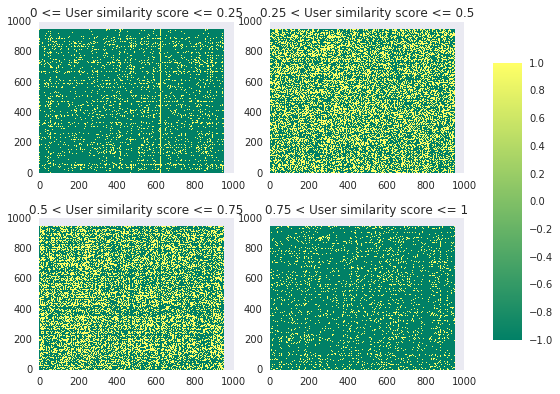

In [170]:
fig, ax = plt.subplots(nrows=2, ncols=2)

fig.tight_layout()
fig.subplots_adjust(hspace=.3)
count = 0

plt.title('Heat map of user similarity matrix')

for row in ax:
    for col in row:
        heatmap = col.pcolor(pruned_user_similarity[count], cmap='summer')
        col.grid(False)
        if count == 0:
            col.set_title('0 <= User similarity score <= 0.25')
        elif count == 1:
            col.set_title('0.25 < User similarity score <= 0.5')
        elif count == 2:
            col.set_title('0.5 < User similarity score <= 0.75')
        else:
            col.set_title('0.75 < User similarity score <= 1')
        count += 1
        
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)
        
plt.show()
fig.savefig('user_similarity.png')

In [128]:
item_index_map = {}
rowsums = item_similarity.sum(axis=0)

count = 0

for i in xrange(1601):
    if rowsums[i] == 1:
        continue
    item_index_map[i] = count
    count += 1
    
n = len(item_index_map)
    
pruned_item_similarity = np.zeros((4, n, n))

for i in xrange(1601):
    if i not in item_index_map:
        continue
    for j in xrange(1601):
        if j not in item_index_map:
            continue
        if item_similarity[i, j] <= 0.25:
            pruned_item_similarity[0, item_index_map[i], item_index_map[j]] = 1
        else:
            pruned_item_similarity[0, item_index_map[i], item_index_map[j]] = -1
        if item_similarity[i, j] <= 0.5 and item_similarity[i, j] > 0.25:
            pruned_item_similarity[1, item_index_map[i], item_index_map[j]] = 1
        else:
            pruned_item_similarity[1, item_index_map[i], item_index_map[j]] = -1
        if item_similarity[i, j] <= 0.75 and item_similarity[i, j] > 0.5:
            pruned_item_similarity[2, item_index_map[i], item_index_map[j]] = 1
        else:
            pruned_item_similarity[2, item_index_map[i], item_index_map[j]] = -1
        if item_similarity[i, j] > 0.75:
            pruned_item_similarity[3, item_index_map[i], item_index_map[j]] = 1
        else:
            pruned_item_similarity[3, item_index_map[i], item_index_map[j]] = -1

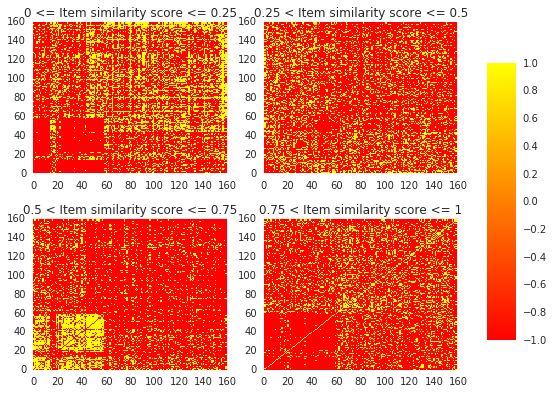

In [168]:
fig, ax = plt.subplots(nrows=2, ncols=2)

fig.tight_layout()
fig.subplots_adjust(hspace=.3)
count = 0

plt.title('Heat map of item similarity matrix')

for row in ax:
    for col in row:
        heatmap = col.pcolor(pruned_item_similarity[count], cmap='autumn')
        col.grid(False)
        if count == 0:
            col.set_title('0 <= Item similarity score <= 0.25')
        elif count == 1:
            col.set_title('0.25 < Item similarity score <= 0.5')
        elif count == 2:
            col.set_title('0.5 < Item similarity score <= 0.75')
        else:
            col.set_title('0.75 < Item similarity score <= 1')
        count += 1
        
        
fig.subplots_adjust(right=0.8)
cbar_ax = fig.add_axes([0.85, 0.15, 0.05, 0.7])
fig.colorbar(heatmap, cax=cbar_ax)
        
plt.show()
fig.savefig('item_similarity.png')

In [174]:
print len(np.argwhere(pruned_item_similarity[0] == 1))
print len(np.argwhere(pruned_item_similarity[1] == 1))
print len(np.argwhere(pruned_item_similarity[2] == 1))
print len(np.argwhere(pruned_item_similarity[3] == 1))

7936
6660
5222
5463
